## Load necessary packages and read in Spotify attribute data

In [1]:
# Load necessary packages and read in df
library(tidyverse)
library(mclust)
library(psych)
library(cluster)
library(dplyr)
df <- read.csv("/kaggle/input/spotify-data/SpotifyFeatures.csv", header=TRUE)
set.seed(12345)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Package 'mclust' version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘mclust’


The following object is masked from ‘package:purrr’:

    map



Attaching package: ‘psych’


The following object is masked from ‘package:mclust’:

    sim


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




In [2]:
# Examine data
head(df)
# Remove duplicated tracks that could result in skewing
df <- df[!duplicated(df$track_id), ]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.9100,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
2,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.7370,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
3,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.1310,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
4,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.3260,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
5,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.2250,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
6,Movie,Henri Salvador,Le petit souper aux chandelles,0Mf1jKa8eNAf1a4PwTbizj,0,0.749,0.578,160627,0.0948,0.000,C#,0.1070,-14.970,Major,0.1430,87.479,4/4,0.358


## Preprocess DataFrame

In [3]:
# Remove non numerical variables
df_ready_for_pca <- df[, !names(df) %in% c('popularity','genre', 'artist_name', 'track_name', 'track_id', 'key', 'mode', 'time_signature')]

# Examine Data
head(df_ready_for_pca)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.611,0.389,99373,0.9100,0.000,0.3460,-1.828,0.0525,166.969,0.814
2,0.246,0.590,137373,0.7370,0.000,0.1510,-5.559,0.0868,174.003,0.816
3,0.952,0.663,170267,0.1310,0.000,0.1030,-13.879,0.0362,99.488,0.368
4,0.703,0.240,152427,0.3260,0.000,0.0985,-12.178,0.0395,171.758,0.227
5,0.950,0.331,82625,0.2250,0.123,0.2020,-21.150,0.0456,140.576,0.390
6,0.749,0.578,160627,0.0948,0.000,0.1070,-14.970,0.1430,87.479,0.358


Since the units are incommensurate, we choose to standardize the dataset to variables with large variances (such as duration_ms and tempo) do not dominate

In [4]:
data_scaled <- scale(df_ready_for_pca)

## Determine number of principal components

First, I will observe the scree plot of the correlation matrix of the standarize data and use the elbow method to identify the number of components. 

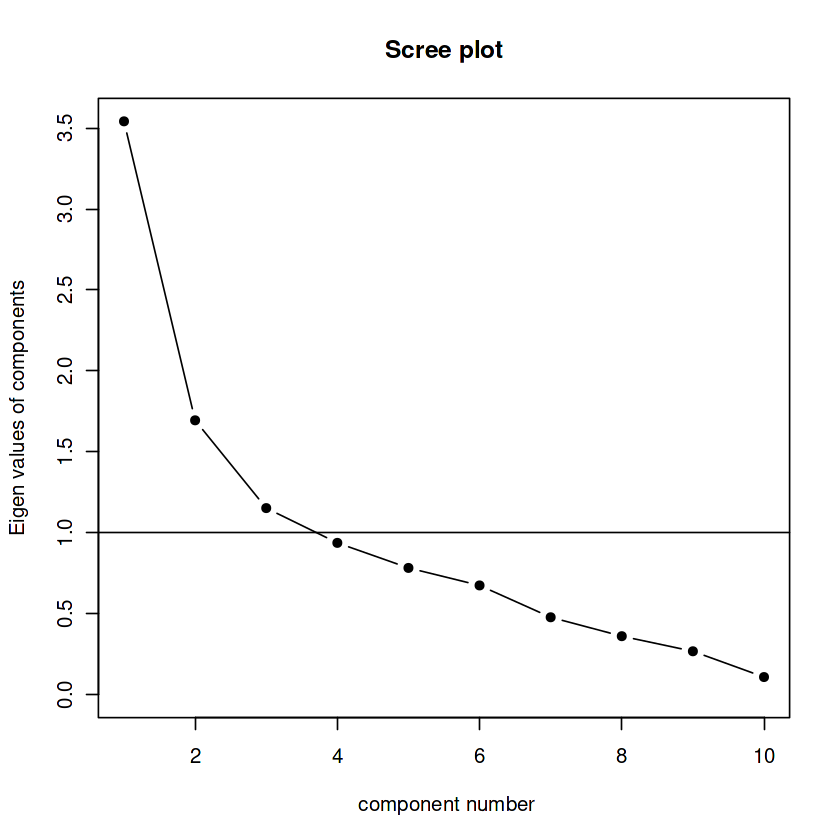

In [5]:
# Plot PCA results
scree(cor(data_scaled), factors=FALSE)

Kaiser Criterion suggests 3 factors, but since component 4 has a eigenvalue close to 1, we will investigate it aswellBased on this, it seems we will need 3 components. Furthermore, utilizing the Kaiser Criterion, we can see that 3 components have eigenvalues greater than 1, suggesting we will need 3 components. However, since the four component has an eigenvalue close to 1, I will also investigate it to see if the loadings are better.

#### 1 Factor

In [6]:
# 1 factor: 
fa_result <- factanal(data_scaled, factors = 1, rotation = "varimax")
print(fa_result, cutoff=0.3, digits=3, sort=TRUE)

pca_result <- principal(data_scaled, nfactors=1, rotate="varimax")
print(pca_result$loadings, cutoff=0.4, digits=3, sort=TRUE)

# For correlation
model2 <- principal(data_scaled, nfactors = 1, rotate = 'promax')

# Correlation for promax
cor(model2$scores)


Call:
factanal(x = data_scaled, factors = 1, rotation = "varimax")

Uniquenesses:
    acousticness     danceability      duration_ms           energy 
           0.403            0.761            0.997            0.185 
instrumentalness         liveness         loudness      speechiness 
           0.754            0.988            0.170            0.996 
           tempo          valence 
           0.926            0.746 

Loadings:
 [1] -0.773  0.903  0.911  0.504  0.489        -0.496                     

               Factor1
SS loadings      3.074
Proportion Var   0.307

Test of the hypothesis that 1 factor is sufficient.
The chi square statistic is 229747.2 on 35 degrees of freedom.
The p-value is 0 

Loadings:
 [1] -0.777  0.661  0.866 -0.617  0.883  0.669                            

                 PC1
SS loadings    3.542
Proportion Var 0.354


,PC1
PC1,1


#### 2 Factor

In [7]:
# 2 factor: 
fa_result <- factanal(data_scaled, factors = 2, rotation = "varimax")
print(fa_result, cutoff=0.3, digits=3, sort=TRUE)

pca_result <- principal(data_scaled, nfactors=2, rotate="varimax")
print(pca_result$loadings, cutoff=0.35, digits=3, sort=TRUE)

# For correlation
model2 <- principal(data_scaled, nfactors = 2, rotate = 'promax')

# Correlation for promax
cor(model2$scores)


Call:
factanal(x = data_scaled, factors = 2, rotation = "varimax")

Uniquenesses:
    acousticness     danceability      duration_ms           energy 
           0.318            0.766            0.998            0.143 
instrumentalness         liveness         loudness      speechiness 
           0.741            0.634            0.188            0.126 
           tempo          valence 
           0.908            0.751 

Loadings:
                 Factor1 Factor2
acousticness     -0.805         
energy            0.910         
loudness          0.901         
liveness                  0.600 
speechiness               0.935 
danceability      0.469         
duration_ms                     
instrumentalness -0.468         
tempo                           
valence           0.498         

               Factor1 Factor2
SS loadings      3.062   1.366
Proportion Var   0.306   0.137
Cumulative Var   0.306   0.443

Test of the hypothesis that 2 factors are sufficient.
The chi square st

,RC1,RC2
RC1,1.00000000,0.06440049
RC2,0.06440049,1.00000000


#### 3 Factor

In [8]:
# 3 factor: 
fa_result <- factanal(data_scaled, factors = 3, rotation = "varimax")
print(fa_result, cutoff=0.3, digits=3, sort=TRUE)
pca_result <- principal(data_scaled, nfactors=3, rotate="varimax")
print(pca_result$loadings, cutoff=0.4, digits=3, sort=TRUE)

# For correlation
model2 <- principal(data_scaled, nfactors = 3, rotate = 'promax')
print(model2$loadings, cutoff=0.3, digits=3, sort=TRUE)

# Correlation for promax
cor(model2$scores)


Call:
factanal(x = data_scaled, factors = 3, rotation = "varimax")

Uniquenesses:
    acousticness     danceability      duration_ms           energy 
           0.313            0.005            0.984            0.048 
instrumentalness         liveness         loudness      speechiness 
           0.756            0.570            0.234            0.196 
           tempo          valence 
           0.904            0.587 

Loadings:
                 Factor1 Factor2 Factor3
acousticness     -0.783                 
energy            0.921                 
loudness          0.819   0.304         
danceability              0.977         
valence           0.369   0.526         
liveness                          0.651 
speechiness                       0.881 
duration_ms                             
instrumentalness -0.333  -0.306         
tempo                                   

               Factor1 Factor2 Factor3
SS loadings      2.520   1.540   1.345
Proportion Var   0.252   0.154

,RC1,RC2,RC3
RC1,1.00000000,0.07074425,0.3302208
RC2,0.07074425,1.00000000,0.1459794
RC3,0.33022081,0.14597937,1.0000000


#### 4 Factor

In [9]:
# 4 factor: 

fa_result <- factanal(data_scaled, factors = 4, rotation = "varimax")
print(fa_result, cutoff=0.3, digits=3, sort=TRUE)

pca_result <- principal(data_scaled, nfactors=4, rotate="varimax")
print(pca_result$loadings, cutoff=0.4, digits=3, sort=TRUE)

# For correlation
model2 <- principal(data_scaled, nfactors = 4, rotate = 'promax')

# Correlation for promax
cor(model2$scores)


Call:
factanal(x = data_scaled, factors = 4, rotation = "varimax")

Uniquenesses:
    acousticness     danceability      duration_ms           energy 
           0.331            0.005            0.984            0.005 
instrumentalness         liveness         loudness      speechiness 
           0.676            0.563            0.005            0.215 
           tempo          valence 
           0.907            0.579 

Loadings:
                 Factor1 Factor2 Factor3 Factor4
acousticness     -0.763                         
energy            0.931                         
loudness          0.778                   0.571 
danceability              0.970                 
valence           0.357   0.541                 
liveness                          0.656         
speechiness                       0.867         
duration_ms                                     
instrumentalness                         -0.372 
tempo                                           

               Facto

,RC1,RC2,RC4,RC3
RC1,1.00000000,0.142743803,0.334277915,0.08031949
RC2,0.14274380,1.000000000,0.004226895,0.04641827
RC4,0.33427791,0.004226895,1.000000000,0.36058434
RC3,0.08031949,0.046418271,0.360584342,1.00000000


#### 5 Factor

In [10]:
# 5 factor: 
fa_result <- factanal(data_scaled, factors = 5, rotation = "varimax")
print(fa_result, cutoff=0.3, digits=3, sort=TRUE)

pca_result <- principal(data_scaled, nfactors=5, rotate="varimax")
print(pca_result$loadings, cutoff=0.4, digits=3, sort=TRUE)

# For correlation
model2 <- principal(data_scaled, nfactors = 5, rotate = 'promax')

# Correlation for promax
cor(model2$scores)


Call:
factanal(x = data_scaled, factors = 5, rotation = "varimax")

Uniquenesses:
    acousticness     danceability      duration_ms           energy 
           0.315            0.005            0.973            0.005 
instrumentalness         liveness         loudness      speechiness 
           0.179            0.556            0.212            0.238 
           tempo          valence 
           0.898            0.005 

Loadings:
                 Factor1 Factor2 Factor3 Factor4 Factor5
acousticness     -0.786                                 
energy            0.944                                 
loudness          0.812                                 
liveness                  0.659                         
speechiness               0.855                         
valence           0.333           0.937                 
danceability                      0.479   0.830         
instrumentalness                                  0.811 
duration_ms                                    

,RC1,RC5,RC2,RC4,RC3
RC1,1.0000000,0.5272046,0.116826597,0.28429590,-0.032885502
RC5,0.5272046,1.0000000,0.158801679,0.13602827,-0.153934144
RC2,0.1168266,0.1588017,1.000000000,-0.06537388,-0.007637112
RC4,0.2842959,0.1360283,-0.065373881,1.00000000,-0.040751685
RC3,-0.0328855,-0.1539341,-0.007637112,-0.04075169,1.000000000


#### Conduct VSS complexit and MAP tests


Very Simple Structure
Call: vss(x = x, n = n, rotate = rotate, diagonal = diagonal, fm = fm, 
    n.obs = n.obs, plot = plot, title = title, use = use, cor = cor)
VSS complexity 1 achieves a maximimum of 0.73  with  2  factors
VSS complexity 2 achieves a maximimum of 0.8  with  3  factors

The Velicer MAP achieves a minimum of 0.05  with  1  factors 
BIC achieves a minimum of  1559.97  with  5  factors
Sample Size adjusted BIC achieves a minimum of  1575.86  with  5  factors

Statistics by number of factors 
  vss1 vss2   map dof   chisq prob sqresid  fit RMSEA    BIC  SABIC complex
1 0.63 0.00 0.053  35 2.3e+05    0     7.1 0.63 0.193 229324 229436     1.0
2 0.73 0.76 0.062  26 1.1e+05    0     4.6 0.76 0.158 114460 114543     1.1
3 0.64 0.80 0.067  18 3.5e+04    0     3.3 0.83 0.105  34959  35017     1.4
4 0.59 0.76 0.124  11 1.3e+04    0     3.1 0.84 0.081  12741  12775     1.5
5 0.61 0.79 0.173   5 1.6e+03    0     2.3 0.88 0.043   1560   1576     1.4
6 0.62 0.79 0.251   0 3.0e+02

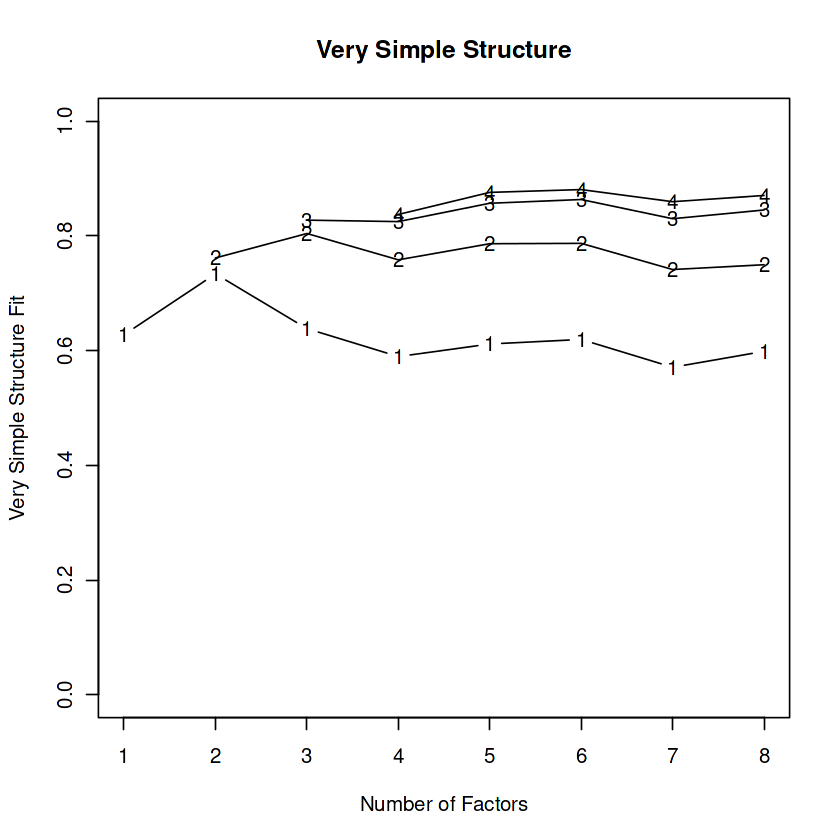

In [11]:
# Conduct the MAP test via the VSS function
vss_result <- VSS(data_scaled, n = 8, rotate = "varimax", fm = "ml")

print(vss_result)

summary(vss_result)

In [12]:
fa_result <- factanal(data_scaled[, -c(5)], factors = 3, rotation = "varimax")
print(fa_result, cutoff=0.3, digits=3, sort=TRUE)

pca_result <- principal(data_scaled[, -c(5)], nfactors=3, rotate="varimax")
print(pca_result$loadings, cutoff=0.4, digits=3, sort=TRUE)

# For correlation
model2 <- principal(data_scaled[, -c(5)], nfactors = 3, rotate = 'promax')

# Correlation for promax
cor(model2$scores)


Call:
factanal(x = data_scaled[, -c(5)], factors = 3, rotation = "varimax")

Uniquenesses:
acousticness danceability  duration_ms       energy     liveness     loudness 
       0.326        0.005        0.984        0.005        0.561        0.258 
 speechiness        tempo      valence 
       0.233        0.907        0.584 

Loadings:
             Factor1 Factor2 Factor3
acousticness -0.775                 
energy        0.941                 
loudness      0.803   0.304         
danceability          0.976         
valence       0.375   0.524         
liveness                      0.658 
speechiness                   0.861 
duration_ms                         
tempo                               

               Factor1 Factor2 Factor3
SS loadings      2.409   1.438   1.290
Proportion Var   0.268   0.160   0.143
Cumulative Var   0.268   0.427   0.571

Test of the hypothesis that 3 factors are sufficient.
The chi square statistic is 10931.86 on 12 degrees of freedom.
The p-value is

,RC1,RC2,RC3
RC1,1.00000000,-0.02459497,0.25390044
RC2,-0.02459497,1.00000000,0.05871346
RC3,0.25390044,0.05871346,1.00000000


Given the loadings from the principal component analysis (PCA) with both varimax and oblique (promax) rotations for three factors, and the low promax correlations suggesting independence among factors. Although a fourth factor was considered, it led to overfactoring, with two components being dominated by single variables, diminishing interpretability without significantly increasing cumulative variance explained.

##### Principal Component 1: Acoustic and Energy Dynamics
###### Variables:
Highly correlated with 'energy', 'loudness', 'acousticness' (negatively), and to a lesser extent, 'tempo' and 'instrumentalness'.

###### Description:
This component emphasizes the contrast between acoustic and electronic elements in music, capturing the dynamic range from soft, more natural sounds to energetic, amplified productions. It mirrors the balance between acoustic purity and the vibrancy of electronic music.

###### Business Implications:
For music producers and platforms, understanding this balance is crucial for curating content that appeals to diverse listener preferences, from acoustic serenity to high-energy beats. It can guide playlist curation for varying activities and moods, from relaxation to intense workouts.

##### Principal Component 2: Expressiveness and Live Experience
###### Variables:
Primarily associated with 'liveness' and 'speechiness', indicating tracks with live performance features and spoken word content.

###### Description:
This component distinguishes tracks with the authentic feel of live performances and spoken elements, potentially including live concerts, stand-up comedy, or spoken-word poetry, highlighting the human and immediate aspect of these recordings.

###### Business Implications:
This insight is invaluable for event organizers, streaming services, and radio programmers to design experiences that resonate with audiences seeking the genuine and unedited expressions of artists. It aids in promoting live event recordings and spoken word content to target demographics.

##### Principal Component 3: Rhythmic and Emotional Depth
###### Variables:
Tied to 'danceability', 'valence' (positivity), and negatively with 'duration_ms', suggesting a preference for shorter, upbeat, and emotionally positive tracks.

###### Description:
This component captures the essence of rhythm and mood in music, favoring tracks that are both danceable and emotionally uplifting. The negative association with 'duration_ms' suggests a lean towards more concise, impactful musical experiences.

###### Business Implications:
For marketers and playlist curators, this component underscores the importance of selecting tracks that boost listener mood and encourage movement, ideal for settings that aim to uplift or energize, such as parties, fitness classes, or retail spaces looking to enhance the shopping experience.


#### Conclusion:

For businesses, the nuanced understanding furnished by this model enables targeted strategic decisions in content curation, marketing, and customer experience. Streaming services, for instance, can refine recommendation algorithms with these insights, curating engaging and contextually resonant playlists. Venues and retailers, too, can utilize the emotional and energetic insights to craft ambient music experiences that align with customer moods and preferences, fostering an engaging atmosphere.

In sum, the adjusted three-factor model stands as a robust analytical framework for leveraging distinctive music characteristics. This approach not only enriches user experience but also underpins varied business applications, aiding in the strategic deployment of music to meet business objectives and enhance customer engagement.

## Clustering

#### View Principal Components Plots

Next I will view the plots of the principal components and see if I can identify any obvious shapes or clusters. This will guide my choice of clustering method to use.

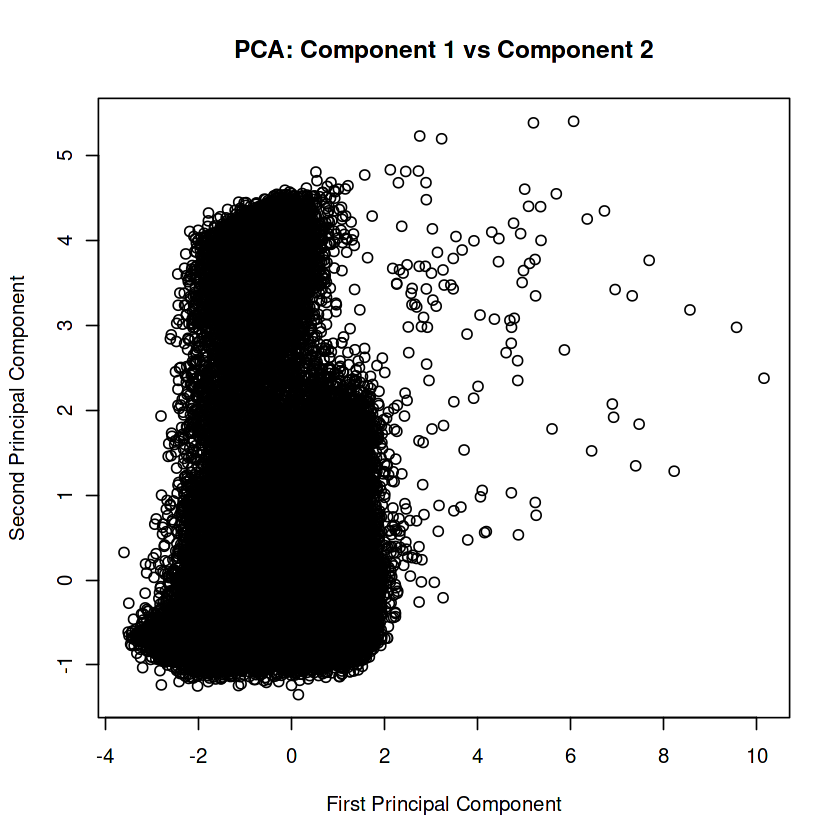

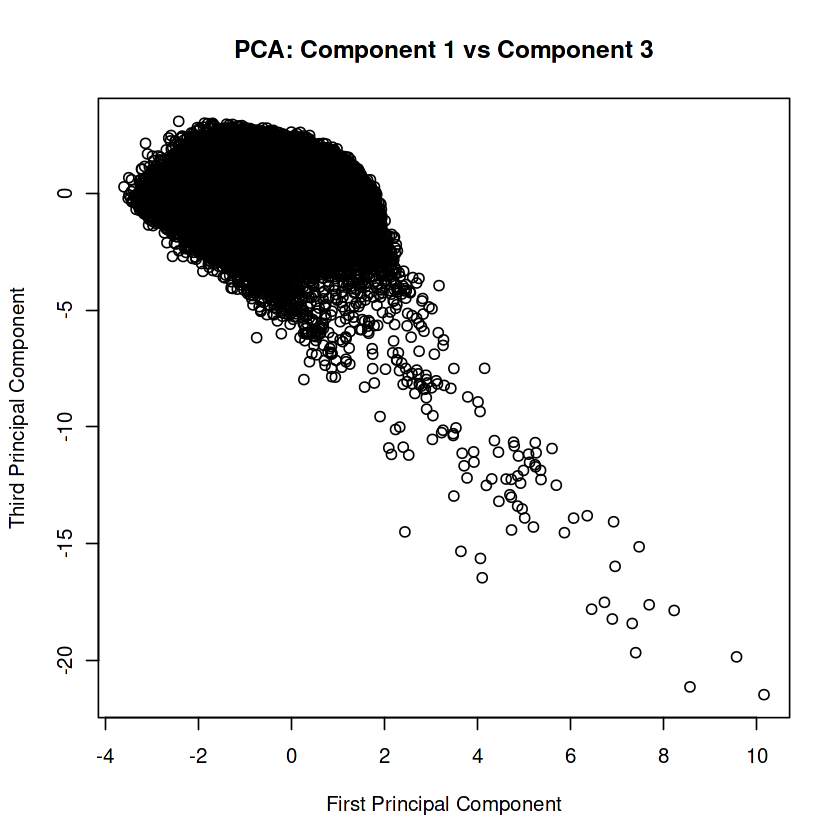

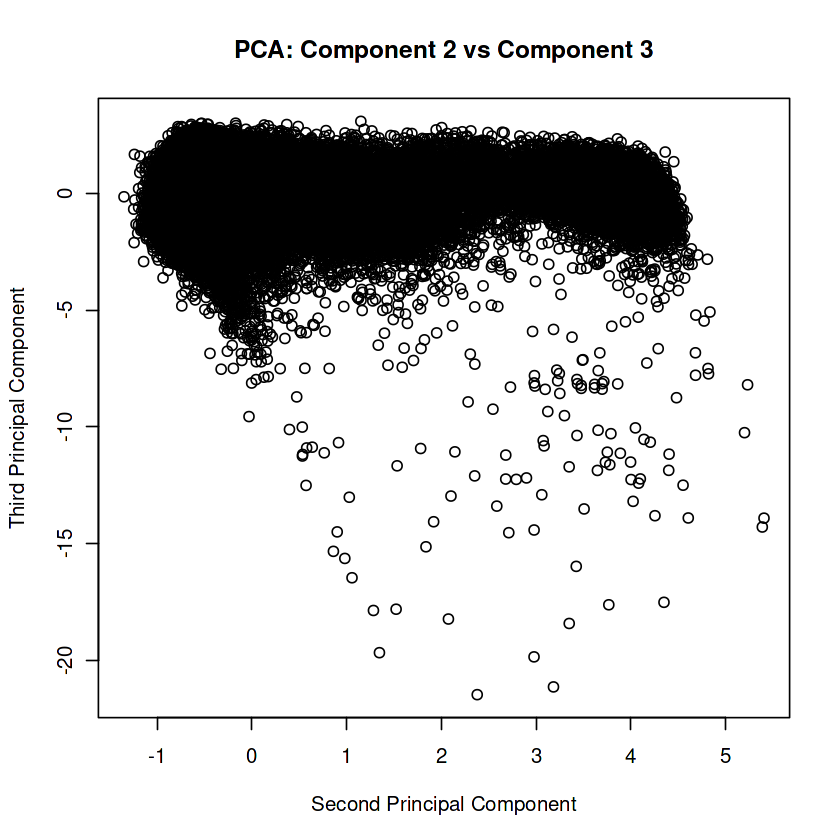

In [13]:
# Plot the first principal component against the second
plot(pca_result$scores[,1], pca_result$scores[,2],
     xlab="First Principal Component",
     ylab="Second Principal Component",
     main="PCA: Component 1 vs Component 2")

plot(pca_result$scores[,1], pca_result$scores[,3],
     xlab="First Principal Component",
     ylab="Third Principal Component",
     main="PCA: Component 1 vs Component 3")

plot(pca_result$scores[,2], pca_result$scores[,3],
     xlab="Second Principal Component",
     ylab="Third Principal Component",
     main="PCA: Component 2 vs Component 3")

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEV (ellipsoidal, equal shape) model with 9 components: 

 log-likelihood      n  df      BIC      ICL
       -1273096 176774 521 -2552487 -2591162

Clustering table:
    1     2     3     4     5     6     7     8     9 
37059 27493 15741 20509 35869  9234  5437  8927 16505 

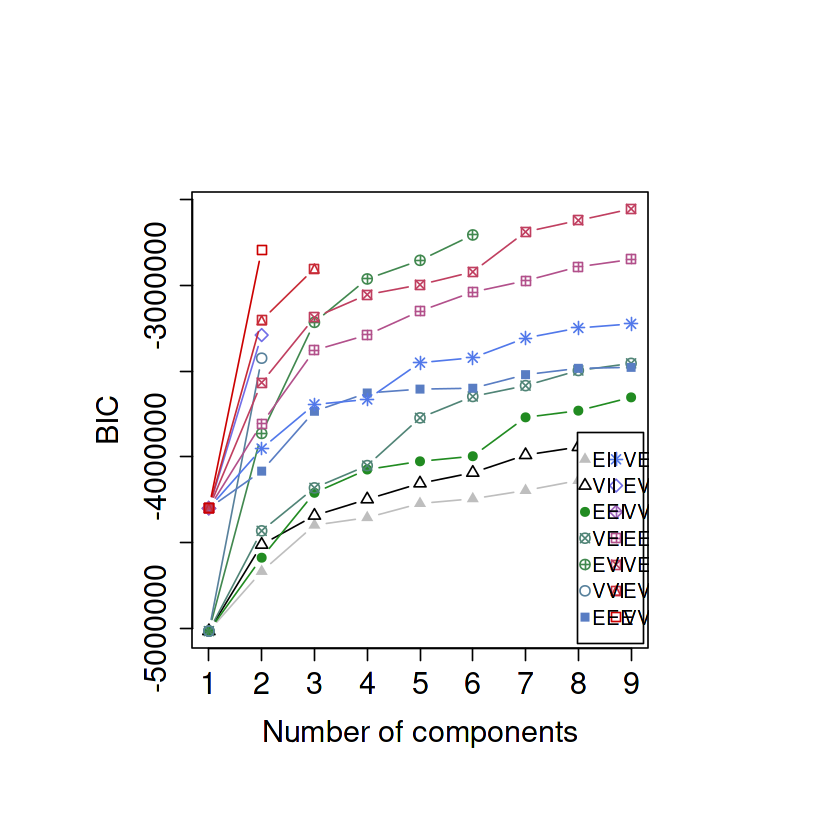

In [14]:
par(mar=c(8, 8, 8, 8) , cex.main=2, cex.lab=1.5, cex.axis=1.5)

mclust_result <- Mclust(data_scaled)

plot(mclust_result, what = "BIC")
summary(mclust_result)

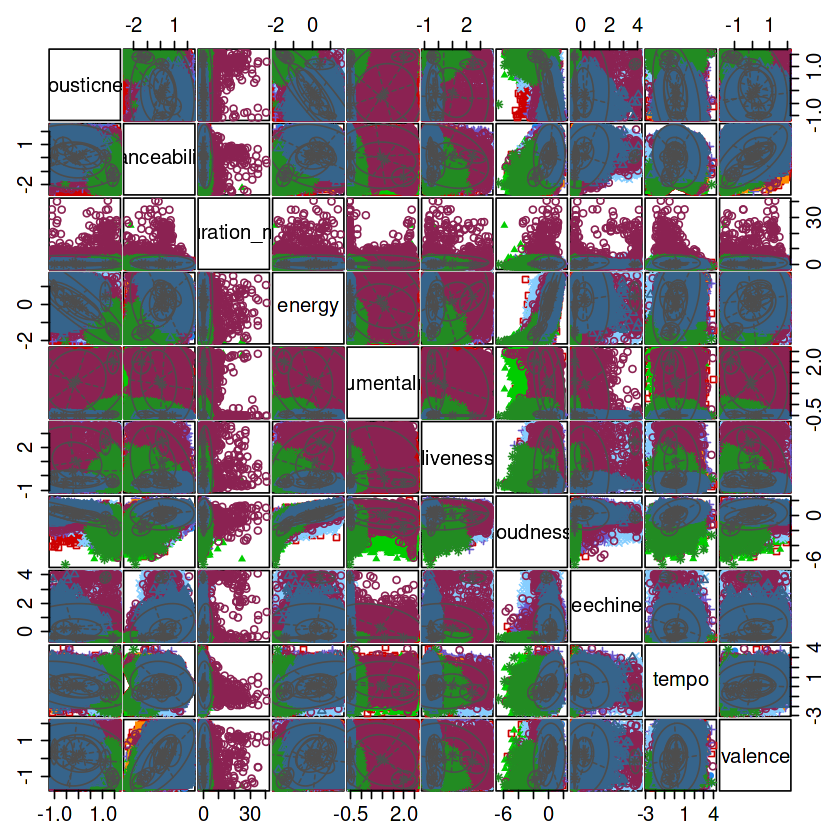

In [15]:
par(mar=c(8, 8, 8, 8) , cex.main=2, cex.lab=1.5, cex.axis=1.5)
plot(mclust_result, what = "classification")

In [16]:
classification <- mclust_result$classification

cluster_means <- aggregate(data_scaled, by=list(cluster=classification), FUN=mean)
cluster_std <- aggregate(data_scaled, by=list(cluster=classification), FUN=sd)

cluster_means <- cluster_means[,-1]
cluster_std <- cluster_std[,-1]

print(round(cluster_means, 3))

print(round(cluster_std, 3))

  acousticness danceability duration_ms energy instrumentalness liveness
1        0.184        0.260      -0.088 -0.203           -0.528   -0.389
2       -0.132       -0.136       0.113 -0.072            1.117   -0.212
3        1.420       -1.414       0.224 -1.540            1.990   -0.514
4       -0.054        0.144       0.008  0.156           -0.521    1.066
5       -1.000        0.179      -0.132  0.881           -0.529   -0.145
6        1.108        0.113      -0.104  0.426           -0.533    2.441
7       -0.255        0.127       0.924  0.259            0.927    0.331
8        1.401       -1.127       0.022 -1.419           -0.465   -0.349
9       -0.601        0.929      -0.186  0.379           -0.531   -0.578
  loudness speechiness  tempo valence
1    0.160      -0.390  0.044   0.247
2   -0.173      -0.397  0.044  -0.102
3   -1.826      -0.425 -0.530  -1.201
4    0.149       0.256  0.107   0.190
5    0.759      -0.302  0.276   0.380
6   -0.299       3.809 -0.629  -0.178
7   

In [17]:
df$cluster <- mclust_result$classification

genre_frequency <- table(df$cluster, df$genre)

genre_frequency_df <- as.data.frame(genre_frequency)

colnames(genre_frequency_df) <- c("Cluster", "Genre", "Frequency")

top_genres_per_cluster <- genre_frequency_df %>%
  group_by(Cluster) %>%
  arrange(desc(Frequency)) %>%
  slice_head(n = 2) %>%
  ungroup()

print(top_genres_per_cluster)

# A tibble: 18 × 3
   Cluster Genre       Frequency
   <fct>   <fct>           <int>
 1 1       Folk             3611
 2 1       Country          3311
 3 2       Electronic       4184
 4 2       Jazz             3262
 5 3       Classical        5089
 6 3       Soundtrack       4754
 7 4       Hip-Hop          1951
 8 4       Opera            1653
 9 5       Ska              4550
10 5       Alternative      4008
11 6       Comedy           8788
12 6       Movie             237
13 7       Electronic       1388
14 7       Jazz              683
15 8       Opera            3305
16 8       Movie            1140
17 9       Hip-Hop          3392
18 9       Reggaeton        2648


##### Cluster 1: Subdued Acoustic
###### Top Genre: Folk
###### Attributes:
Moderate acousticness, danceability, and lower energy; quieter and less lively tracks.
###### Interpretation:
Tracks in this cluster are likely mellow, perhaps suitable for reflective or intimate settings.
###### Business Use:
Ideal for environments that require a calm and relaxing ambiance, like yoga studios or quiet cafes.

##### Cluster 2: Instrumental and Calm
###### Top Genre: Jazz
###### Attributes:
Average acousticness and instrumentalness, lower danceability, energy, and loudness.
###### Interpretation:
This cluster may contain calm instrumental or ambient tracks.
###### Business Use:
Great for spaces where a peaceful or contemplative atmosphere is desired, such as art galleries or libraries.

##### Cluster 3: Mellow and Melodic
###### Top Genre: Classical
###### Attributes:
Very high acousticness and instrumentalness, very low danceability, energy, and loudness.
###### Interpretation:
Likely includes slow, melodic tracks, possibly with orchestral or acoustic instruments.
###### Business Use:
Suitable for environments that benefit from serene background music, like massage parlors or meditation centers.

##### Cluster 4: Live and Energetic
###### Top Genre: Hip-Hop
###### Attributes:
Above-average liveness and speechiness, with moderate energy.
###### Interpretation:
Tracks may include live recordings or songs with significant lyrics or spoken components.
###### Business Use:
Perfect for live venues and social settings where a sense of energy and engagement is beneficial.

##### Cluster 5: Upbeat and Dynamic
###### Top Genre: Alternative
###### Attributes:
Low acousticness with higher energy and loudness, suggesting more dynamic tracks.
###### Interpretation:
Potentially includes a mix of pop, rock, or dance music that's more energetic and lively.
###### Business Use:
Versatile for various commercial settings, such as retail shops, bars, or parties to energize the crowd.

##### Cluster 6: Expressive and Intense
###### Top Genre: Comedy
###### Attributes:
Very high liveness and extremely high speechiness, with moderate energy.
###### Interpretation:
Could consist of tracks with prominent live and spoken word elements, indicating intense expression.
###### Business Use:
Suitable for events that focus on performance arts, spoken word, or other live expressions.

##### Cluster 7: Instrumental Focus
###### Top Genre: Electronic
###### Attributes:
Longer duration, high instrumentalness, and moderate liveness.
###### Interpretation:
Tracks might be longer instrumental pieces, perhaps with live performance elements.
###### Business Use:
Good for background ambiance where distraction should be minimal, like study spaces or bookstores.

##### Cluster 8: Calm and Melancholic
###### Top Genre: Opera
###### Attributes:
High acousticness, low danceability and energy, and very low loudness.
###### Interpretation:
May include genres like classical or soft indie, with melancholic or somber tones.
###### Business Use:
Fitting for spaces requiring subdued music, such as fine dining restaurants or quiet waiting areas.

##### Cluster 9: Popularity and Tempo
###### Top Genre: Hip-Hop
###### Attributes:
Lower acousticness, high danceability, and moderate tempo and loudness.
###### Interpretation:
Likely includes popular music genres that are catchy and designed for broad appeal.
###### Business Use:
Ideal for commercial environments aiming to create a mainstream appeal, like malls or casual dining.




Understanding these clusters allows businesses to tailor their music offerings to enhance the customer experience. By aligning the musical atmosphere with the brand's identity and the desired mood, businesses can influence customer behavior, dwell time, and even spending habits. For streaming services, these clusters could inform recommendation algorithms, helping to surface songs that align with listeners' current activities or mood, thereby increasing user engagement and satisfaction. For artists and record labels, insights from these clusters can guide marketing strategies and track selection for albums or playlists, targeting the right audience with the right music.